In [1]:
## CLASIFICACION DE NOTICIAS EN CATEGORÍAS ##
carpetaDatos='./dataset/'
carpetaLibs='./libs/'
import nltk
import pandas as pd
from tqdm import tqdm

#Importamos librerías locales
import sys
sys.path.append(carpetaLibs)
import preprocesamiento_textos as prepro
import ML_textos as mlt

#Dataset de noticias preprocesadas
df_noticias = pd.read_csv(carpetaDatos+'dataset_final.csv')

Using TensorFlow backend.
/usr/work01/eduardo/python_venv/venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/work01/eduardo/python_venv/venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/work01/eduardo/python_venv/venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/work01/ed

In [3]:
#### ALGUNOS INSIGHTS SOBRE EL DATASET: ##
## CADA FILA ES UNA NOTICIA DE UNA CATEGORÍA
## TENEMOS 59.451 NOTICIAS REGISTRADAS
df_noticias.count()

Unnamed: 0      59451
ID              59451
Fecha           59451
Contenido       59451
Id_Categoria    59451
Categoria       59451
dtype: int64

In [4]:
#DATASET DESBALANCEADO: EXISTEN CATEGORÍAS CON MUCHAS MÁS INSTANCIAS QUE LAS DEMÁS#
df_noticias.groupby(['Categoria']).count()

,Unnamed: 0,ID,Fecha,Contenido,Id_Categoria
Categoria,,,,,
Cultura,1118,1118,1118,1118,1118
Deportes,7441,7441,7441,7441,7441
Economía y Negocios,1305,1305,1305,1305,1305
Espectáculos,3291,3291,3291,3291,3291
Internacionales,2031,2031,2031,2031,2031
Locales,10320,10320,10320,10320,10320
Mundo,1228,1228,1228,1228,1228
Nacionales,10760,10760,10760,10760,10760
Policiales,10811,10811,10811,10811,10811


In [5]:
#Balanceamos el dataset para la fase de entrenamiento y test
g=df_noticias.groupby('Categoria')
df_noticias=pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))
df_noticias['Categoria'].value_counts()

Policiales             1118
Nacionales             1118
Política               1118
Internacionales        1118
Cultura                1118
Locales                1118
Mundo                  1118
Deportes               1118
Espectáculos           1118
Economía y Negocios    1118
Provinciales           1118
Name: Categoria, dtype: int64

In [6]:
#Limpiamos los textos sin quitar stopwords
noticias_fase1=[]
for texto in tqdm(df_noticias['Contenido']):
  textoLimpio=prepro.quitar_digitos(prepro.quitar_signos_puntuacion(prepro.tokenizar(texto.lower())))
  noticias_fase1.append(textoLimpio)
df_auxiliar=pd.DataFrame({'Contenido':noticias_fase1})
prepro.guardar_datos_pickle(noticias_fase1,carpetaDatos+'noticias_fase1.dat')
#noticias_fase1=prepro.cargar_datos_pickle(carpetaDatos+'noticias_fase1.dat')

In [7]:
#Obtenemos bigrams
#listas_bigrams=prepro.cargar_datos_pickle(carpetaDatos+'obj_bigrams_noticias.dat')
listas_bigrams=prepro.obtener_bigrams(noticias_fase1)
noticias_fase2 = [listas_bigrams[noticia] for noticia in tqdm(noticias_fase1)]
prepro.guardar_datos_pickle(noticias_fase2,carpetaDatos+'noticias_para_w2v_2018_con_bigrams.dat')
prepro.guardar_datos_pickle(listas_bigrams,carpetaDatos+'obj_bigrams_noticias.dat')
#noticias_fase2=prepro.cargar_datos_pickle(carpetaDatos+'noticias_para_w2v_2018_con_bigrams.dat')

In [8]:
#Armamos y guardamos modelo w2v con bigrams
w2v_model=prepro.modelo_word2vec(noticias_fase2)
w2v_model.save(carpetaDatos+'modelo_w2v_noticias_con_bigrams.model')
#Para cargar el modelo, descomentar las líneas de abajo y comentar las de arriba
#from gensim.models import Word2Vec
#w2v_model = Word2Vec.load(carpetaDatos+'modelo_w2v_noticias_con_bigrams.model')

/usr/work01/eduardo/python_venv/venv/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


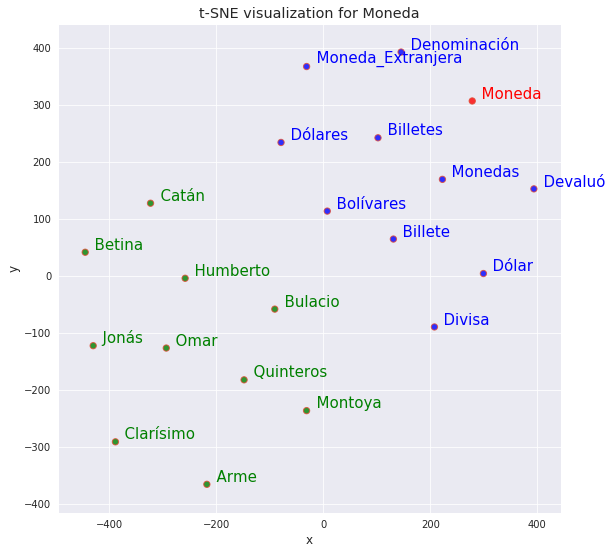

In [9]:
#prepro.grafico_modelo_w2v(w2v_model, 'inmueble', ['dni','perro','arma','lateral','celular'])
prepro.grafico_modelo_w2v(w2v_model, 'moneda', [i[0] for i in w2v_model.most_similar(negative=["moneda"])])

In [10]:
#Calculamos la cantidad de palabras por relato (mediana)  
prepro.mediana_de_cant_palabras(noticias_fase2)

343.0

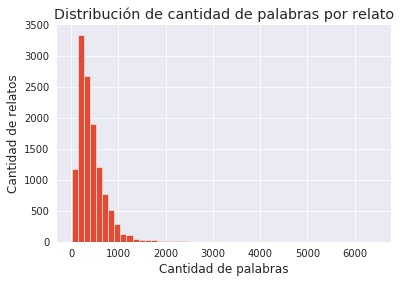

In [11]:
#Gráfico de distribución de cantidades de palabras
prepro.distribucion_cant_palabras(noticias_fase2)

In [12]:
#Parámetros para el resto del script
maxlen = 800
embedding_dim = 300
cant_clases = 11
num_words_vocab=50000

#Obtenemos dataset procesado para ML
df_noticias_clasif=df_noticias[['Contenido','Categoria']]
X,y,tokenizer=mlt.procesar_textos_tokenizados(df_noticias_clasif,num_words_vocab,maxlen)
#X.shape
prepro.guardar_datos_pickle(X,carpetaDatos+'matriz_X_noticias.dat')
prepro.guardar_datos_pickle(y,carpetaDatos+'matriz_y_noticias.dat')
prepro.guardar_datos_pickle(tokenizer,carpetaDatos+'tokenizer_noticias.dat')

#Creamos matriz de embeddings desde el modelo de lenguaje
embedding_matrix=mlt.matriz_embeddings(w2v_model,tokenizer,embedding_dim)
prepro.guardar_datos_pickle(embedding_matrix,carpetaDatos+'embedding_matrix_noticias_low_tok_pun_dig_big_stop.dat')

X.shape#(59451, 800)
#X[0,:1100]

  4%|▍         | 545/12298 [00:00<00:02, 5430.05it/s]

Uniendo tokens de oraciones


100%|██████████| 12298/12298 [00:01<00:00, 6828.81it/s]


(12298, 800)

In [13]:
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Conv1D
from keras.layers import Flatten

dropout=0.4
embedding_dim=embedding_matrix.shape[1]
vocab_size=embedding_matrix.shape[0]
model = Sequential()

#Capa Embeddings
model.add(layers.Embedding(input_dim=vocab_size,
    output_dim=embedding_dim,
    input_length=maxlen,
    weights=[embedding_matrix],
    trainable=False))
#Dropout
model.add(Dropout(dropout))

#Capas CNN 1D
model.add(layers.Conv1D(filters=128, kernel_size=15, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(Dropout(dropout))
model.add(layers.Conv1D(filters=64, kernel_size=10, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(Dropout(dropout))
model.add(layers.Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(Dropout(dropout))

#Agregamos capa de flatten para que no llegue un array tridimensional a la capa densa
model.add(Flatten())

#Capas BiLSTM
#recurrent_dropout=0.4
#model.add(Bidirectional(LSTM(500,return_sequences=True,dropout=dropout,recurrent_dropout=recurrent_dropout)))
#model.add(Bidirectional(LSTM(400,return_sequences=False,dropout=dropout,recurrent_dropout=recurrent_dropout)))

#Capa de clasificación
model.add(layers.Dense(cant_clases, activation='softmax'))

#Todavía no usamos una métrica como auc, ya que en esta etapa solamente obtendremos los pesos de la red CNN
model.compile(optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 800, 300)          60600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 800, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 786, 128)          576128    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 393, 128)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 393, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 384, 64)           81984     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 192, 64)           0         
__________

In [20]:
##Primer entrenamiento de la red, para obtener los pesos de las capas CNN
history = model.fit(X, y,
    epochs=20,
    verbose=True,
    #validation_data=(X_test, y_test_onehot),
    batch_size=256)
#Guardamos modelo y pesos
model_json=model.to_json()
with open(carpetaDatos+'modeloRepCNN.json','w') as json_file:
    json_file.write(model_json)
model.save_weights(carpetaDatos+'modeloRepCNN.h5')

Epoch 1/20
12298/12298 [==============================] - 278s 23ms/step - loss: 0.9160 - acc: 0.6703
Epoch 2/20
12298/12298 [==============================] - 278s 23ms/step - loss: 0.9016 - acc: 0.6729
Epoch 3/20
12298/12298 [==============================] - 396s 32ms/step - loss: 0.8937 - acc: 0.6724
Epoch 4/20
12298/12298 [==============================] - 444s 36ms/step - loss: 0.9053 - acc: 0.6723
Epoch 5/20
12298/12298 [==============================] - 443s 36ms/step - loss: 0.8980 - acc: 0.6762
Epoch 6/20
12298/12298 [==============================] - 445s 36ms/step - loss: 0.8916 - acc: 0.6792
Epoch 7/20
12298/12298 [==============================] - 446s 36ms/step - loss: 0.8901 - acc: 0.6776
Epoch 8/20
12298/12298 [==============================] - 446s 36ms/step - loss: 0.9259 - acc: 0.6670
Epoch 9/20
12298/12298 [==============================] - 446s 36ms/step - loss: 0.8835 - acc: 0.6824
Epoch 10/20
12298/12298 [==============================] - 447s 36ms/step - loss: 

In [2]:
#Leer modelo representacional
from keras.models import model_from_json

json_file=open(carpetaDatos+'modeloRepCNN.json','r')
loaded_model_json=json_file.read()
json_file.close()
model=model_from_json(loaded_model_json)
model.load_weights(carpetaDatos+'modeloRepCNN.h5')

X=prepro.cargar_datos_pickle(carpetaDatos+'matriz_X_noticias.dat')
y=prepro.cargar_datos_pickle(carpetaDatos+'matriz_y_noticias.dat')
tokenizer=prepro.cargar_datos_pickle(carpetaDatos+'tokenizer_noticias.dat')

In [3]:
#PARA OBTENER LA SALIDA DEL MODELO PARA UNA CAPA EN PARTICULAR, EN ESTE CASO LA ÚLTIMA CNN (Flatten)
import numpy as np
from keras import backend as K
get_cnn_layer_output = K.function([model.layers[0].input],
                                  [model.layers[11].output])

cant_textos=X.shape[0]
cant_caracteres=X.shape[1]
aux=[get_cnn_layer_output([X[i].reshape(1,cant_caracteres)])[0][0] for i in tqdm(range(cant_textos))]
X_cnn=np.asarray(aux)
X_cnn.shape

100%|██████████| 12298/12298 [03:15<00:00, 62.88it/s]


(12298, 3008)

In [8]:
#Probamos Decision Tree, SVM y Perceptrón Multicapa
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn import svm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf
import numpy as np
from keras.utils import np_utils

#Hack para calcular métrica auc_roc en entrenamiento de nn
def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

scores=[]
kf=KFold(n_splits=5,shuffle=True)
for train_index, test_index in kf.split(X_cnn):
    X_train,X_test=X_cnn[train_index],X_cnn[test_index]
    y_train,y_test=y[train_index],y[test_index]
    X_train_normalized=preprocessing.normalize(X_train)
    X_test_normalized=preprocessing.normalize(X_test)
    
    #Árbol de decisión
    arbol=DecisionTreeClassifier()
    arbol=arbol.fit(X_train_normalized, y_train)
    y_pred_arbol=arbol.predict(X_test_normalized)
    score_arbol=roc_auc_score(y_test,y_pred_arbol)
    print('AUC Árbol:{}'.format(score_arbol))
    
    #SVM
    y_train_svm=np.argmax(y_train,axis=1)
    y_test_svm=np.argmax(y_test,axis=1)
    cl_svm=svm.SVC()
    cl_svm.fit(X_train_normalized,y_train_svm)
    y_pred_svm=cl_svm.predict(X_test_normalized)
    y1=np_utils.to_categorical(y_test_svm)
    y2=np_utils.to_categorical(y_pred_svm)
    score_svm=roc_auc_score(y1,y2)
    print('AUC SVM:{}'.format(score_svm))
    
    #Perceptrón Multicapa de 3 capas
    model = Sequential()
    model.add(Dense(250, activation='relu',input_dim=X_train.shape[1]))
    model.add(Dropout(0.4))
    model.add(Dense(125, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(11, activation='softmax'))
    model.compile(optimizer='adam',
          loss='categorical_crossentropy',
          metrics=[auroc])
    model.fit(X_train_normalized, y_train,
        epochs=20,
        verbose=False,
        batch_size=256)
    y_pred_perceptron=model.predict(X_test_normalized)
    score_nn=roc_auc_score(y_test,y_pred_perceptron)
    print('AUC NN:{}'.format(roc_auc_score(y_test,y_pred_perceptron)))
    
    #Guardamos valores de AUC para cada modelo en la iteración
    scores.append([score_arbol,score_svm,score_nn])

AUC Árbol:0.5862579743084306
AUC SVM:0.8886882049725856
AUC NN:0.9846507767550015
AUC Árbol:0.5804871989846645
AUC SVM:0.8770556757666337
AUC NN:0.9827922498418414
AUC Árbol:0.5968693634226606
AUC SVM:0.8826260243422258
AUC NN:0.9831494406739018
AUC Árbol:0.5883619207746769
AUC SVM:0.8766106802038586
AUC NN:0.9812364825364537
AUC Árbol:0.5894786096643
AUC SVM:0.8874624216206303
AUC NN:0.9837248561686821


In [15]:
import pandas as pd
from scipy import stats

puntajes=pd.DataFrame(scores)
puntajes.to_csv(carpetaDatos+'puntajes.csv')

#Calculamos estadístico t de Student a los puntajes
print('t-test para Árboles de Decisión vs SVM: {}'.format(stats.ttest_ind(puntajes[0],puntajes[1])))
print('t-test para Árboles de Decisión vs Perceptrón Multicapa: {}'.format(stats.ttest_ind(puntajes[0],puntajes[2])))
print('t-test para SVM vs Perceptrón Multicapa: {}'.format(stats.ttest_ind(puntajes[1],puntajes[2])))

t-test para Árboles de Decisión vs SVM: Ttest_indResult(statistic=-80.47445917794018, pvalue=6.339037374267414e-13)
t-test para Árboles de Decisión vs Perceptrón Multicapa: Ttest_indResult(statistic=-145.92913137814645, pvalue=5.438696291312656e-15)
t-test para SVM vs Perceptrón Multicapa: Ttest_indResult(statistic=-38.92836827085366, pvalue=2.0838005626385238e-10)
